In [44]:
def model(data):
    alpha0 = torch.tensor(10.)
    beta0 = torch.tensor(10.)
    f = pyro.sample('latent_fairness', dist.Beta(alpha0, beta0))
    for i in pyro.iarange('data_loop', len(data)):
        pyro.sample('obs', dist.Bernoulli(f), obs=data)

In [459]:
import numpy as np

scale = 1

X = np.linspace(-4, 4, 100)[:, None] / scale
train_X = np.random.choice(X[:, 0], size=50)[:, None]
train_y = np.abs(np.sin(train_X * scale))
y = np.sin(X)

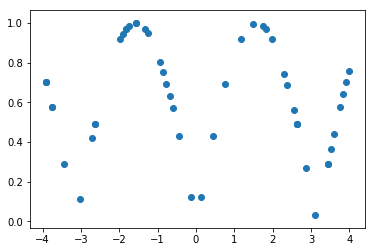

In [460]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(train_X, train_y)

In [461]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO

In [462]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers=2):
        super(MLP, self).__init__()
        self.layers = []
        for i in range(num_layers):
            if i == 0:
                idim = input_dim
            else:
                idim = hidden_dim
            odim = hidden_dim
            layer = nn.Linear(idim, odim)
            self.layers.append(layer)
        self.layers.append(nn.Linear(hidden_dim, output_dim))
        self.layers = nn.ModuleList(self.layers)
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return self.layers[-1](x)
    


In [463]:
import math


def inverse_softplus(x):
    return math.log(math.exp(x) - 1)

class NP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, rep_dim, noise=1.0):
        super(NP, self).__init__()
        self.enc_input_dim = input_dim + output_dim
        self.enc_output_dim = rep_dim
        self.dec_input_dim = rep_dim + input_dim
        self.dec_output_dim = output_dim
        self.encoder = MLP(self.enc_input_dim, self.enc_output_dim, hidden_dim)
        self.decoder = MLP(self.dec_input_dim, self.dec_output_dim, hidden_dim)
        self.loc_lin = nn.Linear(rep_dim, hidden_dim)
        self.scale_lin = nn.Linear(rep_dim, hidden_dim)
        # self.noise_inverse = inverse_softplus(1.0)
        self.noise = noise
        
    def model(self, Xc, yc, X, y):
        # Register all model parameters
        pyro.module('NP', self)
        # Producde represenation
        # noise_param = pyro.param('noise_inverse', torch.tensor(self.noise_inverse))
        # noise_param = F.softplus(noise_param)
        features_ctxt = torch.cat((Xc, yc), 1)
        rep = self.encoder(features_ctxt)
        rep = self._process_rep(rep)
        # Generate hidden
        loc = self.loc_lin(rep)
        scale = F.softplus(self.scale_lin(rep))
        hidden = pyro.sample('hidden', dist.Normal(loc, scale).independent(1))
        # Predict test data
        Xt = torch.cat((Xc, X), 0)
        yt = torch.cat((yc, y), 0)
        n_batch = Xt.size(0)
        hidden_t = hidden.repeat([n_batch, 1])
        features_t = torch.cat((Xt, hidden_t), 1)
        obs_mean = self.decoder(features_t)
        pyro.sample('obs', dist.Normal(obs_mean, self.noise), obs=yt)
    
    def guide(self, Xc, yc, X, y):
        n_batch = X.size(0)
        # Register all model parameters
        pyro.module('NP', self)
        # Producde represenation with both context data and test data
        X_all = torch.cat((Xc, X), 0)
        y_all = torch.cat((yc, y), 0)
        features = torch.cat((X_all, y_all), 1)
        rep = self.encoder(features)
        rep = self._process_rep(rep)
        # Generate hidden
        loc = self.loc_lin(rep)
        scale = F.softplus(self.scale_lin(rep))
        hidden = pyro.sample('hidden', dist.Normal(loc, scale).independent(1))
        
    
    def sample(self, Xc, yc, X, num_samples=1):
        n_batch = X.size(0)
        # Producde represenation
        features_ctxt = torch.cat((Xc, yc), 1)
        rep = self.encoder(features_ctxt)
        rep = self._process_rep(rep)
        # Generate hidden
        loc = self.loc_lin(rep)
        scale = F.softplus(self.scale_lin(rep))
        hidden_dist = dist.Normal(loc, scale).independent(1)
        hidden = hidden_dist.sample(torch.Size([num_samples, 1]))
        print(np.std(hidden.detach().numpy(), 0))
        n_batch = X.size(0)
        hidden_ = hidden.repeat([1, n_batch, 1])
        X_ = X.repeat([num_samples, 1, 1])
        # Predict test data
        features = torch.cat((X_, hidden_), -1)
        pred_mean = self.decoder(features)
        # noise_param = F.softplus(pyro.param('noise_inverse'))
        return pred_mean
    
    
    def predict(self, Xc, yc, X, num_samples=100):
        Xc = torch.tensor(Xc).float()
        yc = torch.tensor(yc).float()
        X = torch.tensor(X).float()
        samples = self.sample(Xc, yc, X, num_samples)
        mean = torch.mean(samples, 0).detach().numpy()
        std = torch.std(samples, 0).detach().numpy()
        std = (std * self.noise) / (std + self.noise)
        return mean, std
        
        
    def _process_rep(self, x):
        return torch.mean(x, 0)

In [464]:
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split


def train(X, y, model, optimizer, num_epochs=100, ctxt_ratio=0.5):
    svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())
    idx = np.arange(len(X))
    X = torch.tensor(X).float()
    y = torch.tensor(y).float()
    for i in tqdm_notebook(range(num_epochs)):
        idx_t, idx_c = train_test_split(idx, test_size=ctxt_ratio)
        Xc = X[idx_c]
        yc = y[idx_c]
        Xt = X[idx_t]
        yt = y[idx_t]
        epoch_loss = svi.step(Xc, yc, Xt, yt)
        if i % 100 == 0:
            print(epoch_loss)

In [465]:
input_dim = 1
hidden_dim = 4
rep_dim = 4
output_dim = 1
num_epochs = 10000

pyro.clear_param_store()

model = NP(input_dim, output_dim, hidden_dim, rep_dim, noise=1.0e-2)
optimizer = pyro.optim.Adam({'lr': 1.0e-2})

train(train_X, train_y, model, optimizer, num_epochs, ctxt_ratio=.5)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

78636.697265625
18079.900859355927
17915.156786203384
17038.722742021084
15612.614574790001
14299.818828582764
13964.161402225494
13879.11500453949
13662.495804786682
6020.749669075012
3496.3047046661377
3230.7340412139893
2852.185929298401
2758.3876361846924
3385.4415760040283
2488.949475288391
2466.071997642517
2449.444200515747
2341.643162727356
2390.4259090423584
2415.3144607543945
2354.481475830078
2349.061839580536
2349.348066329956
2375.573579788208
2451.777856826782
2344.1453914642334
2282.893036842346
2337.1861181259155
2284.724709510803
2323.2816228866577
2542.910140991211
2684.070700645447
2273.520047187805
2362.3214254379272
2264.3292379379272
2331.2452325820923
2271.2428765296936
2473.466527938843
2605.7125816345215
2313.158473968506
2283.093638420105
2267.185815811157
2321.790415763855
2266.0105209350586
2272.335376739502
2307.994441986084
2270.100350379944
2282.603313446045
2271.2757720947266
2265.4732427597046
2277.9555892944336
2330.950090408325
2263.6338119506836
2320

Exception ignored in: <bound method Trace.__del__ of <pyro.poutine.trace_struct.Trace object at 0x7efe6e287860>>
Traceback (most recent call last):
  File "/home/tom/anaconda3/lib/python3.6/site-packages/pyro/poutine/trace_struct.py", line 109, in __del__
    self._graph.__dict__.clear()
KeyboardInterrupt


2492.285804748535
2291.657467842102
2281.472553253174
2332.293429374695
2258.7435054779053
2287.915761947632
2312.53475856781
2266.4049072265625
2264.173454284668
2270.6301345825195


KeyboardInterrupt: 

In [466]:
pred_mean, pred_std = model.predict(train_X, train_y, X, 100)

[[0.00425191 0.00510004 0.00233543 0.00808721]]


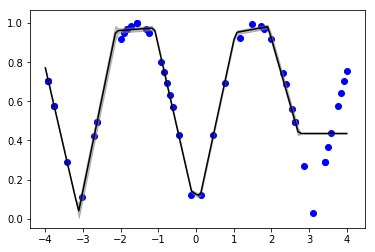

In [467]:
# pred_mean = np.mean(predictions, 0)
# pred_std = np.std(predictions, 0)
plt.plot(X, pred_mean, color='k')
plt.scatter(train_X, train_y, color='b')
plt.fill_between(X[:, 0], pred_mean[:, 0] - 10 * pred_std[:, 0],
                 pred_mean[:, 0] + 10 * pred_std[:, 0], color='gray', alpha='.5')

In [458]:
pred_std

array([[0.00137281],
       [0.00137282],
       [0.00137281],
       [0.00137282],
       [0.00137283],
       [0.00137282],
       [0.00137281],
       [0.00137283],
       [0.00137281],
       [0.00137285],
       [0.00137282],
       [0.00137283],
       [0.00137283],
       [0.00137284],
       [0.00137283],
       [0.00137281],
       [0.00137283],
       [0.00137283],
       [0.00137283],
       [0.00137285],
       [0.00137283],
       [0.00137281],
       [0.00137281],
       [0.0013728 ],
       [0.0013728 ],
       [0.0013728 ],
       [0.00137281],
       [0.00137281],
       [0.00137283],
       [0.00137279],
       [0.00137281],
       [0.00137283],
       [0.00137278],
       [0.00137279],
       [0.00107266],
       [0.00107266],
       [0.00107265],
       [0.00107269],
       [0.00107263],
       [0.00107266],
       [0.00107267],
       [0.00107266],
       [0.00107271],
       [0.00107268],
       [0.00107271],
       [0.00107266],
       [0.00107269],
       [0.001

In [265]:
pyro.param('noise_inverse')

tensor(-1.0468)

In [409]:
x = torch.randn(10, 3)
torch.mean(x, 0)

tensor([ 0.2037, -0.5940, -0.0524])

In [410]:
torch.std(x, 0)

tensor([ 0.8799,  0.9923,  0.8428])

In [317]:

x.sample(torch.Size([3, 1])).shape

torch.Size([3, 1, 2])